## Análisis y predicción del consumo energético en Europa


### Introducción

En este proyecto analizamos los patrones de consumo energético en Europa y construimos un modelo predictivo para estimar el consumo futuro.
Utilizamos datos abiertos y técnicas avanzadas de análisis y modelado.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

Carga y preparación de datos

In [6]:
data_path = "data/time_series_60min_singleindex.csv"
df = pd.read_csv(data_path, parse_dates=['utc_timestamp'], index_col='utc_timestamp')

In [7]:
df.head(10)

,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,734.81,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
2015-01-01 02:00:00+00:00,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,766.64,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
2015-01-01 03:00:00+00:00,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,733.13,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN
2015-01-01 04:00:00+00:00,2015-01-01T05:00:00+0100,5309.0,6609.0,35.0,NaN,64.0,8487.0,8806.0,NaN,730.99,...,998.67,824.0,NaN,1.60,2626.0,2790.0,3.8,NaN,NaN,NaN
2015-01-01 05:00:00+00:00,2015-01-01T06:00:00+0100,5574.0,6543.0,35.0,NaN,84.0,8428.0,8805.0,NaN,820.66,...,1045.17,886.0,NaN,0.00,2641.0,2830.0,3.8,NaN,NaN,NaN
2015-01-01 06:00:00+00:00,2015-01-01T07:00:00+0100,5925.0,6851.0,36.0,NaN,131.0,8122.0,8651.0,NaN,940.12,...,1085.06,985.0,NaN,0.00,2622.0,2790.0,3.8,NaN,NaN,NaN
2015-01-01 07:00:00+00:00,2015-01-01T08:00:00+0100,6343.0,7061.0,36.0,2.0,109.0,8179.0,8674.0,NaN,1087.66,...,1142.36,1109.0,NaN,0.00,2691.0,2980.0,3.9,NaN,NaN,NaN


In [9]:
df.columns.tolist()

['cet_cest_timestamp',
 'AT_load_actual_entsoe_transparency',
 'AT_load_forecast_entsoe_transparency',
 'AT_price_day_ahead',
 'AT_solar_generation_actual',
 'AT_wind_onshore_generation_actual',
 'BE_load_actual_entsoe_transparency',
 'BE_load_forecast_entsoe_transparency',
 'BE_solar_generation_actual',
 'BE_wind_generation_actual',
 'BE_wind_offshore_generation_actual',
 'BE_wind_onshore_generation_actual',
 'BG_load_actual_entsoe_transparency',
 'BG_load_forecast_entsoe_transparency',
 'BG_solar_generation_actual',
 'BG_wind_onshore_generation_actual',
 'CH_load_actual_entsoe_transparency',
 'CH_load_forecast_entsoe_transparency',
 'CH_solar_capacity',
 'CH_solar_generation_actual',
 'CH_wind_onshore_capacity',
 'CH_wind_onshore_generation_actual',
 'CY_load_actual_entsoe_transparency',
 'CY_load_forecast_entsoe_transparency',
 'CY_wind_onshore_generation_actual',
 'CZ_load_actual_entsoe_transparency',
 'CZ_load_forecast_entsoe_transparency',
 'CZ_solar_generation_actual',
 'CZ_wind

### Análisis Exploratorio de Datos (EDA)

Filtramos las columnas de interés: Consumo total y consumo total por región

In [10]:
filtered_columns = [col for col in df.columns if "_load_actual_entsoe_transparency" in col]


In [11]:
if len(filtered_columns) == 0:
    print("No se encontraron columnas relacionadas con el consumo energético. Verifica el dataset.")
else:
    print(f"Columnas seleccionadas: {filtered_columns}")


Columnas seleccionadas: ['AT_load_actual_entsoe_transparency', 'BE_load_actual_entsoe_transparency', 'BG_load_actual_entsoe_transparency', 'CH_load_actual_entsoe_transparency', 'CY_load_actual_entsoe_transparency', 'CZ_load_actual_entsoe_transparency', 'DE_load_actual_entsoe_transparency', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_LU_load_actual_entsoe_transparency', 'DE_amprion_load_actual_entsoe_transparency', 'DE_tennet_load_actual_entsoe_transparency', 'DE_transnetbw_load_actual_entsoe_transparency', 'DK_load_actual_entsoe_transparency', 'DK_1_load_actual_entsoe_transparency', 'DK_2_load_actual_entsoe_transparency', 'EE_load_actual_entsoe_transparency', 'ES_load_actual_entsoe_transparency', 'FI_load_actual_entsoe_transparency', 'FR_load_actual_entsoe_transparency', 'GB_GBN_load_actual_entsoe_transparency', 'GB_NIR_load_actual_entsoe_transparency', 'GB_UKM_load_actual_entsoe_transparency', 'GR_load_actual_entsoe_transparency', 'HR_load_actual_entsoe_transparency', 'HU_load_a

In [12]:
edf = df[filtered_columns]
edf.head(10)

,AT_load_actual_entsoe_transparency,BE_load_actual_entsoe_transparency,BG_load_actual_entsoe_transparency,CH_load_actual_entsoe_transparency,CY_load_actual_entsoe_transparency,CZ_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,DE_50hertz_load_actual_entsoe_transparency,DE_LU_load_actual_entsoe_transparency,DE_amprion_load_actual_entsoe_transparency,...,RO_load_actual_entsoe_transparency,RS_load_actual_entsoe_transparency,SE_load_actual_entsoe_transparency,SE_1_load_actual_entsoe_transparency,SE_2_load_actual_entsoe_transparency,SE_3_load_actual_entsoe_transparency,SE_4_load_actual_entsoe_transparency,SI_load_actual_entsoe_transparency,SK_load_actual_entsoe_transparency,UA_load_actual_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,5946.0,9484.0,NaN,NaN,NaN,NaN,41151.0,6839.0,NaN,15163.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,5726.0,9152.0,4585.0,7640.14,NaN,5957.57,40135.0,6955.0,NaN,14826.0,...,NaN,NaN,14485.0,1092.0,1835.0,9277.0,2281.0,1045.47,2728.0,NaN
2015-01-01 02:00:00+00:00,5347.0,8799.0,4440.0,7391.44,NaN,5878.87,39106.0,7094.0,NaN,14405.0,...,NaN,NaN,14298.0,1059.0,1794.0,9132.0,2313.0,1004.79,2626.0,NaN
2015-01-01 03:00:00+00:00,5249.0,8567.0,4418.0,7332.57,NaN,5827.80,38765.0,7364.0,NaN,14083.0,...,NaN,NaN,14249.0,1019.0,1775.0,9083.0,2372.0,983.79,2618.0,NaN
2015-01-01 04:00:00+00:00,5309.0,8487.0,4393.0,7002.08,NaN,5730.89,38941.0,7992.0,NaN,13810.0,...,NaN,NaN,14268.0,990.0,1752.0,9102.0,2424.0,998.67,2626.0,NaN
2015-01-01 05:00:00+00:00,5574.0,8428.0,4441.0,7043.26,NaN,5668.53,39045.0,9104.0,NaN,13396.0,...,NaN,NaN,14655.0,1045.0,1862.0,9353.0,2395.0,1045.17,2641.0,NaN
2015-01-01 06:00:00+00:00,5925.0,8122.0,4637.0,6836.73,NaN,5600.76,40206.0,10218.0,NaN,13312.0,...,NaN,NaN,14994.0,1066.0,1872.0,9567.0,2489.0,1085.06,2622.0,NaN
2015-01-01 07:00:00+00:00,6343.0,8179.0,4834.0,6616.56,NaN,5651.05,41133.0,10685.0,NaN,13583.0,...,NaN,NaN,15163.0,1033.0,1908.0,9629.0,2593.0,1142.36,2691.0,NaN


In [13]:
def null_percentage(series):
    return (series.isnull().sum() / len(series)) * 100

In [14]:
nulls = edf.apply(null_percentage)
print("Porcentaje de valores nulos por columna:")
print(nulls)

Porcentaje de valores nulos por columna:
AT_load_actual_entsoe_transparency                0.001984
BE_load_actual_entsoe_transparency                0.001984
BG_load_actual_entsoe_transparency                0.128966
CH_load_actual_entsoe_transparency                0.005952
CY_load_actual_entsoe_transparency               34.662011
CZ_load_actual_entsoe_transparency                0.218250
DE_load_actual_entsoe_transparency                0.001984
DE_50hertz_load_actual_entsoe_transparency        0.001984
DE_LU_load_actual_entsoe_transparency            65.230849
DE_amprion_load_actual_entsoe_transparency        0.001984
DE_tennet_load_actual_entsoe_transparency         0.001984
DE_transnetbw_load_actual_entsoe_transparency     0.001984
DK_load_actual_entsoe_transparency                0.005952
DK_1_load_actual_entsoe_transparency              0.005952
DK_2_load_actual_entsoe_transparency              0.005952
EE_load_actual_entsoe_transparency                0.164679
ES_load_actual_

Vemos los valores nulos que hay en cada columna.

In [15]:
columns_with_nulls = nulls[nulls > 0].index.tolist()
if columns_with_nulls:
    print(f"Columnas con valores nulos: {columns_with_nulls}")
    print(edf[columns_with_nulls].isnull().sum())
else:
    print("No hay valores nulos significativos en las columnas seleccionadas.")

Columnas con valores nulos: ['AT_load_actual_entsoe_transparency', 'BE_load_actual_entsoe_transparency', 'BG_load_actual_entsoe_transparency', 'CH_load_actual_entsoe_transparency', 'CY_load_actual_entsoe_transparency', 'CZ_load_actual_entsoe_transparency', 'DE_load_actual_entsoe_transparency', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_LU_load_actual_entsoe_transparency', 'DE_amprion_load_actual_entsoe_transparency', 'DE_tennet_load_actual_entsoe_transparency', 'DE_transnetbw_load_actual_entsoe_transparency', 'DK_load_actual_entsoe_transparency', 'DK_1_load_actual_entsoe_transparency', 'DK_2_load_actual_entsoe_transparency', 'EE_load_actual_entsoe_transparency', 'ES_load_actual_entsoe_transparency', 'FI_load_actual_entsoe_transparency', 'FR_load_actual_entsoe_transparency', 'GB_GBN_load_actual_entsoe_transparency', 'GB_NIR_load_actual_entsoe_transparency', 'GB_UKM_load_actual_entsoe_transparency', 'GR_load_actual_entsoe_transparency', 'HR_load_actual_entsoe_transparency', 'HU_lo

Rellenamos valores nulos.

In [16]:
edf = edf.ffill().bfill()

In [17]:
edf.head(10)

,AT_load_actual_entsoe_transparency,BE_load_actual_entsoe_transparency,BG_load_actual_entsoe_transparency,CH_load_actual_entsoe_transparency,CY_load_actual_entsoe_transparency,CZ_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,DE_50hertz_load_actual_entsoe_transparency,DE_LU_load_actual_entsoe_transparency,DE_amprion_load_actual_entsoe_transparency,...,RO_load_actual_entsoe_transparency,RS_load_actual_entsoe_transparency,SE_load_actual_entsoe_transparency,SE_1_load_actual_entsoe_transparency,SE_2_load_actual_entsoe_transparency,SE_3_load_actual_entsoe_transparency,SE_4_load_actual_entsoe_transparency,SI_load_actual_entsoe_transparency,SK_load_actual_entsoe_transparency,UA_load_actual_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,5946.0,9484.0,4585.0,7640.14,478.0,5957.57,41151.0,6839.0,41874.0,15163.0,...,6626.95,5614.0,14485.0,1092.0,1835.0,9277.0,2281.0,1045.47,2728.0,13373.0
2015-01-01 00:00:00+00:00,5946.0,9484.0,4585.0,7640.14,478.0,5957.57,41151.0,6839.0,41874.0,15163.0,...,6626.95,5614.0,14485.0,1092.0,1835.0,9277.0,2281.0,1045.47,2728.0,13373.0
2015-01-01 01:00:00+00:00,5726.0,9152.0,4585.0,7640.14,478.0,5957.57,40135.0,6955.0,41874.0,14826.0,...,6626.95,5614.0,14485.0,1092.0,1835.0,9277.0,2281.0,1045.47,2728.0,13373.0
2015-01-01 02:00:00+00:00,5347.0,8799.0,4440.0,7391.44,478.0,5878.87,39106.0,7094.0,41874.0,14405.0,...,6626.95,5614.0,14298.0,1059.0,1794.0,9132.0,2313.0,1004.79,2626.0,13373.0
2015-01-01 03:00:00+00:00,5249.0,8567.0,4418.0,7332.57,478.0,5827.80,38765.0,7364.0,41874.0,14083.0,...,6626.95,5614.0,14249.0,1019.0,1775.0,9083.0,2372.0,983.79,2618.0,13373.0
2015-01-01 04:00:00+00:00,5309.0,8487.0,4393.0,7002.08,478.0,5730.89,38941.0,7992.0,41874.0,13810.0,...,6626.95,5614.0,14268.0,990.0,1752.0,9102.0,2424.0,998.67,2626.0,13373.0
2015-01-01 05:00:00+00:00,5574.0,8428.0,4441.0,7043.26,478.0,5668.53,39045.0,9104.0,41874.0,13396.0,...,6626.95,5614.0,14655.0,1045.0,1862.0,9353.0,2395.0,1045.17,2641.0,13373.0
2015-01-01 06:00:00+00:00,5925.0,8122.0,4637.0,6836.73,478.0,5600.76,40206.0,10218.0,41874.0,13312.0,...,6626.95,5614.0,14994.0,1066.0,1872.0,9567.0,2489.0,1085.06,2622.0,13373.0
2015-01-01 07:00:00+00:00,6343.0,8179.0,4834.0,6616.56,478.0,5651.05,41133.0,10685.0,41874.0,13583.0,...,6626.95,5614.0,15163.0,1033.0,1908.0,9629.0,2593.0,1142.36,2691.0,13373.0


Mostramos los valores en la gráfica:

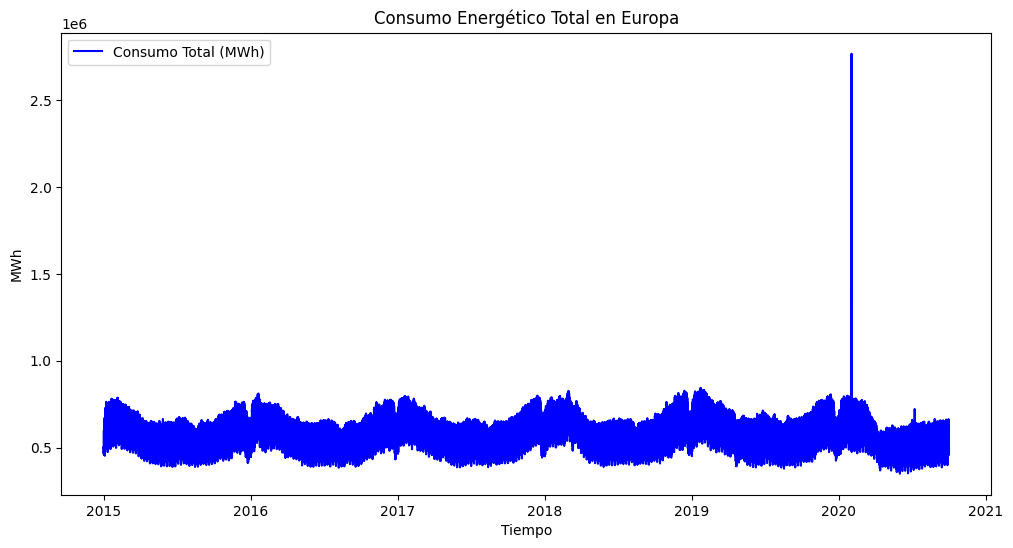

In [18]:
total_consumption = edf.sum(axis=1)
plt.figure(figsize=(12, 6))
plt.plot(total_consumption, label='Consumo Total (MWh)', color='blue')
plt.title("Consumo Energético Total en Europa")
plt.xlabel("Tiempo")
plt.ylabel("MWh")
plt.legend()
plt.show()

Observamos un outlier en el año 2020, así que vamos a corregirlo.

In [19]:
# Calculamos el percentil 99 para detectar outliers
upper_limit = edf.quantile(0.99)

# Aplicar el límite superior correctamente a cada columna
for col in edf.columns:
    edf[col] = np.where(edf[col] > upper_limit[col], upper_limit[col], edf[col])

print("Valores atípicos han sido corregidos usando el percentil 99.")

Valores atípicos han sido corregidos usando el percentil 99.


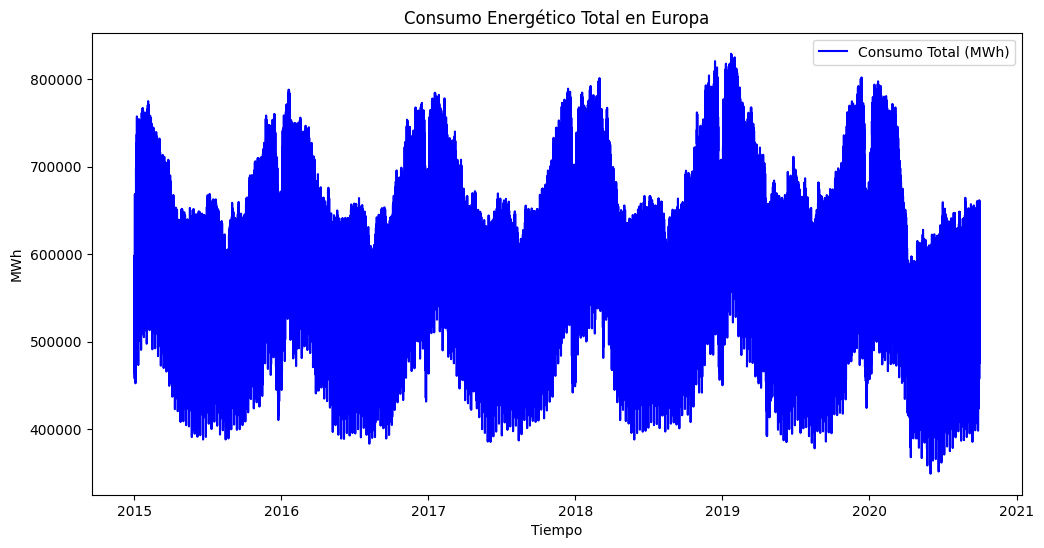

In [20]:
total_consumption = edf.sum(axis=1)
plt.figure(figsize=(12, 6))
plt.plot(total_consumption, label='Consumo Total (MWh)', color='blue')
plt.title("Consumo Energético Total en Europa")
plt.xlabel("Tiempo")
plt.ylabel("MWh")
plt.legend()
plt.show()

Observamos que se nos disparan los valores de MWh, por lo que lo corregimos:

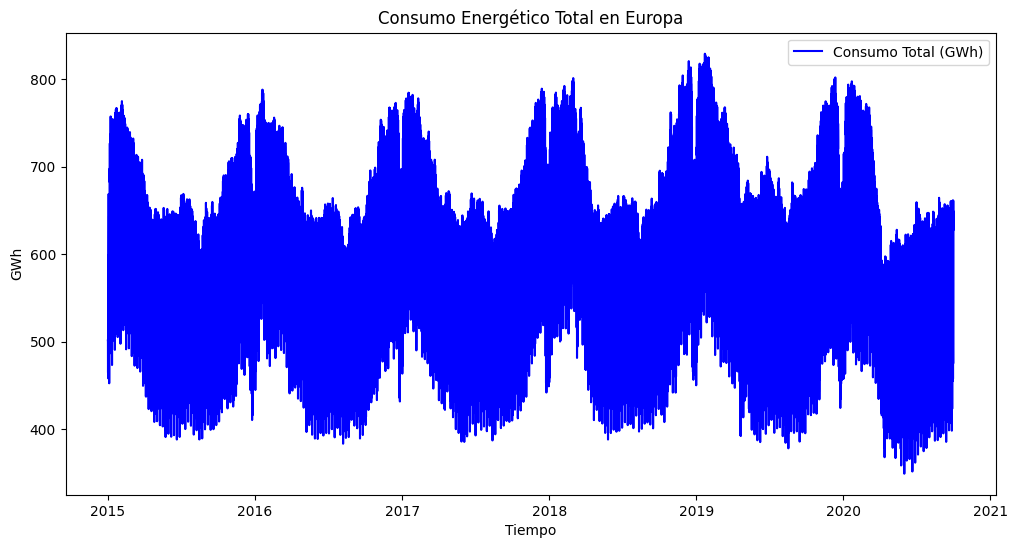

In [21]:
total_consumption = edf.sum(axis=1) / 1000  # Convertir de MWh a GWh
plt.figure(figsize=(12, 6))
plt.plot(total_consumption, label='Consumo Total (GWh)', color='blue')
plt.title("Consumo Energético Total en Europa")
plt.xlabel("Tiempo")
plt.ylabel("GWh")
plt.legend()
plt.show()

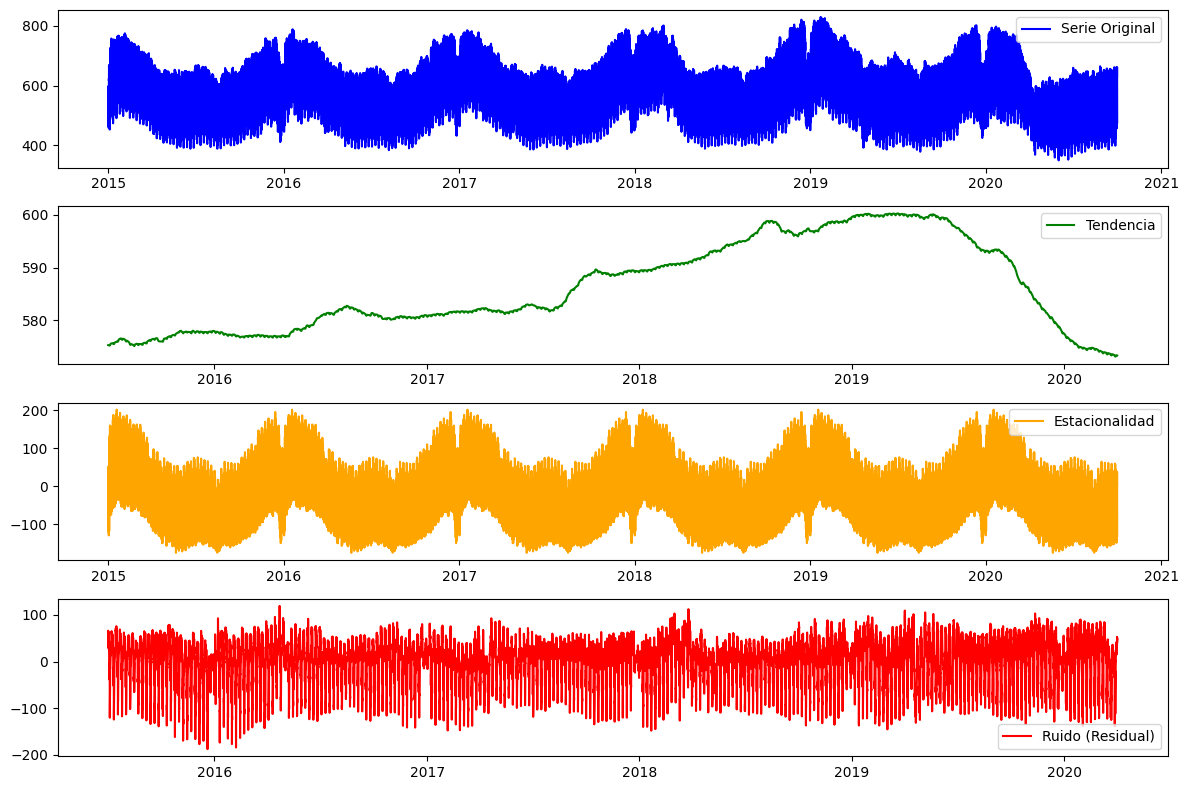

In [22]:
result = seasonal_decompose(total_consumption, model='additive', period=365*24)  # Periodo anual en horas
    
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(total_consumption, label='Serie Original', color='blue')
plt.legend()
    
plt.subplot(412)
plt.plot(result.trend, label='Tendencia', color='green')
plt.legend()
    
plt.subplot(413)
plt.plot(result.seasonal, label='Estacionalidad', color='orange')
plt.legend()
    
plt.subplot(414)
plt.plot(result.resid, label='Ruido (Residual)', color='red')
plt.legend()
    
plt.tight_layout()
plt.show()



1️⃣ Serie original (gráfico azul):

Refleja el consumo total de energía en GWh.
Se observan claramente las fluctuaciones estacionales anuales.

2️⃣ Tendencia (gráfico verde):

Muestra un crecimiento del consumo entre 2015 y 2019, alcanzando su punto máximo en 2019.
A partir de 2020, la tendencia desciende, posiblemente debido a eventos como la pandemia de COVID-19 o cambios en la demanda energética.

3️⃣ Estacionalidad (gráfico naranja):

Se observan patrones cíclicos bien definidos cada año.
El consumo parece ser más alto en invierno y más bajo en verano, lo que es consistente con un mayor uso de calefacción en los meses fríos.

4️⃣ Ruido (gráfico rojo):

Captura variaciones no explicadas por la tendencia ni la estacionalidad.
Se observan fluctuaciones más pronunciadas en algunos periodos, lo que podría deberse a eventos extraordinarios o datos atípicos.

### Modelado predictivo

Preparamos los datos.

In [23]:
df_ml = total_consumption.to_frame().reset_index()
df_ml.columns = ['ds', 'y']  # Renombrar columnas para consistencia
df_ml['ds'] = pd.to_datetime(df_ml['ds'])  # Asegurar que 'ds' sea datetime

Creamos características temporales:

In [24]:
df_ml['year'] = df_ml['ds'].dt.year
df_ml['month'] = df_ml['ds'].dt.month
df_ml['day'] = df_ml['ds'].dt.day
df_ml['dayofweek'] = df_ml['ds'].dt.dayofweek

Agregamos lag features (valores pasados)

In [25]:
df_ml['lag_1'] = df_ml['y'].shift(1)
df_ml['lag_7'] = df_ml['y'].shift(7)  # Semana anterior
df_ml['lag_30'] = df_ml['y'].shift(30)  # Mes anterior

Agregamos media movil.

In [26]:
df_ml['rolling_mean_7'] = df_ml['y'].rolling(window=7).mean()
df_ml['rolling_mean_30'] = df_ml['y'].rolling(window=30).mean()

Eliminamos valores nulos.

In [27]:
df_ml.dropna(inplace=True)

In [28]:
X = df_ml[['year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7', 'rolling_mean_30']]
y = df_ml['y']

# Dividir en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Entrenamos los modelos:

In [29]:
# Modelo XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)

# Modelo Random Forest
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)

RandomForestRegressor()

Predicciones:

In [30]:
y_pred_xgb = model_xgb.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

Evaluamos los modelos.

In [31]:
# ---- EVALUAR MODELOS ----
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"XGBoost - RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}")
print(f"Random Forest - RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}")

XGBoost - RMSE: 11.04, MAE: 7.75
Random Forest - RMSE: 10.32, MAE: 6.91


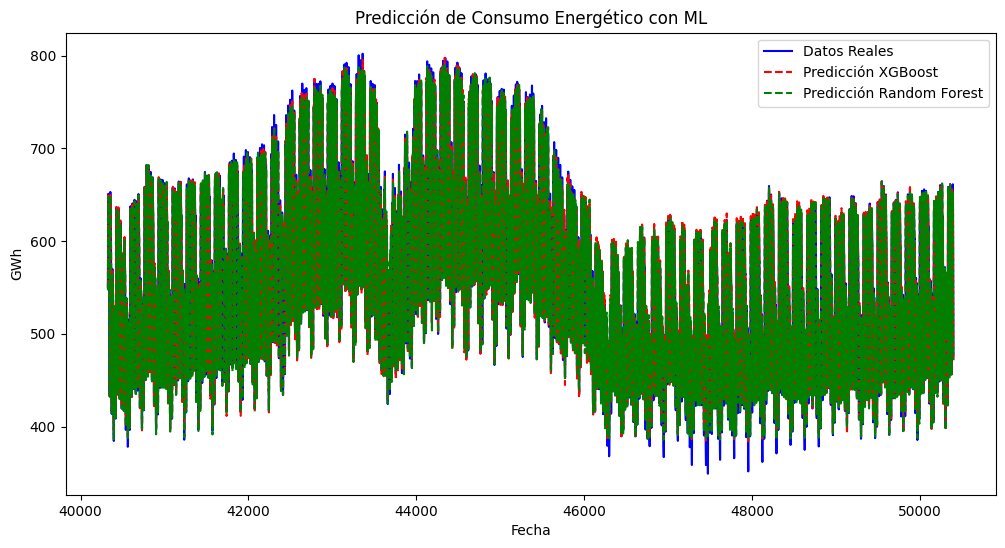

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Datos Reales', color='blue')
plt.plot(y_test.index, y_pred_xgb, label='Predicción XGBoost', color='red', linestyle='dashed')
plt.plot(y_test.index, y_pred_rf, label='Predicción Random Forest', color='green', linestyle='dashed')
plt.title("Predicción de Consumo Energético con ML")
plt.xlabel("Fecha")
plt.ylabel("GWh")
plt.legend()
plt.show()

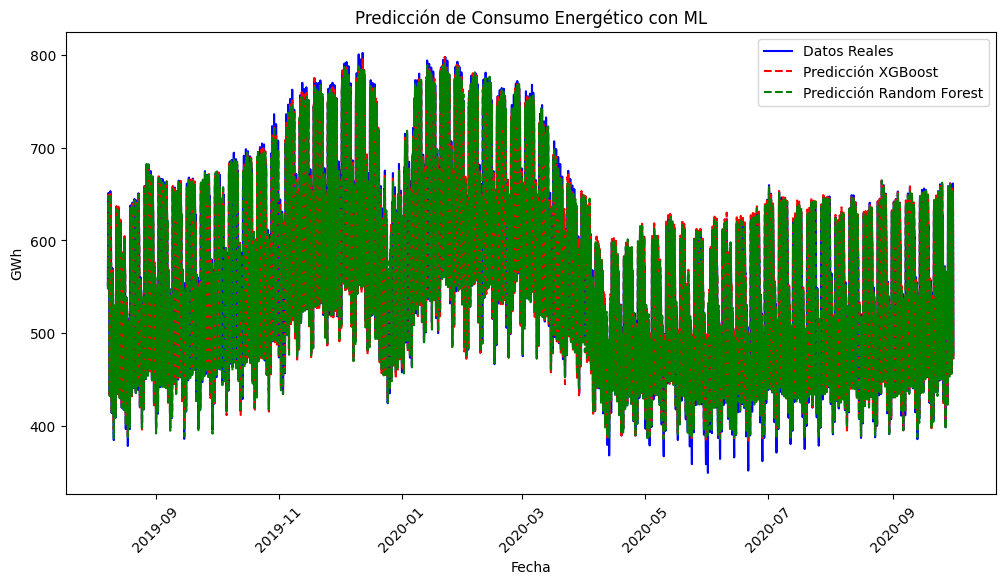

In [33]:
plt.figure(figsize=(12, 6))

# Usar el índice de fechas correctas
plt.plot(df_ml['ds'].iloc[len(X_train):], y_test, label='Datos Reales', color='blue')
plt.plot(df_ml['ds'].iloc[len(X_train):], y_pred_xgb, label='Predicción XGBoost', color='red', linestyle='dashed')
plt.plot(df_ml['ds'].iloc[len(X_train):], y_pred_rf, label='Predicción Random Forest', color='green', linestyle='dashed')

plt.title("Predicción de Consumo Energético con ML")
plt.xlabel("Fecha")
plt.ylabel("GWh")
plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mayor claridad
plt.legend()
plt.show()

Observamos que ambos modelos tienen resultados muy parecidos, pero el modelo Random Forest tiene menor error, por lo que nos centraremos en este. A continuación ajustaremos hiperparámetros y agregaremos más características para mejorar el modelo.

In [34]:
# Definir hiperparámetros para ajustar
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Búsqueda aleatoria de hiperparámetros
random_search_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_grid_rf, n_iter=10, cv=3, verbose=2, n_jobs=-1)
random_search_rf.fit(X_train, y_train)

# Mejor modelo encontrado
best_rf = random_search_rf.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred_best_rf = best_rf.predict(X_test)

# Evaluar modelo ajustado
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)

print(f"Mejor Random Forest - RMSE: {rmse_best_rf:.2f}, MAE: {mae_best_rf:.2f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   8.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   8.8s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   8.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  14.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  14.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  14.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  26.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  26.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  13.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total ti

Podemos observar que tenemos el Random Forest ajustado, ya que el error sale incluso mayor después de ajustar los hiperparámetros.

### Predicción del consumo energético futuro (365 días)

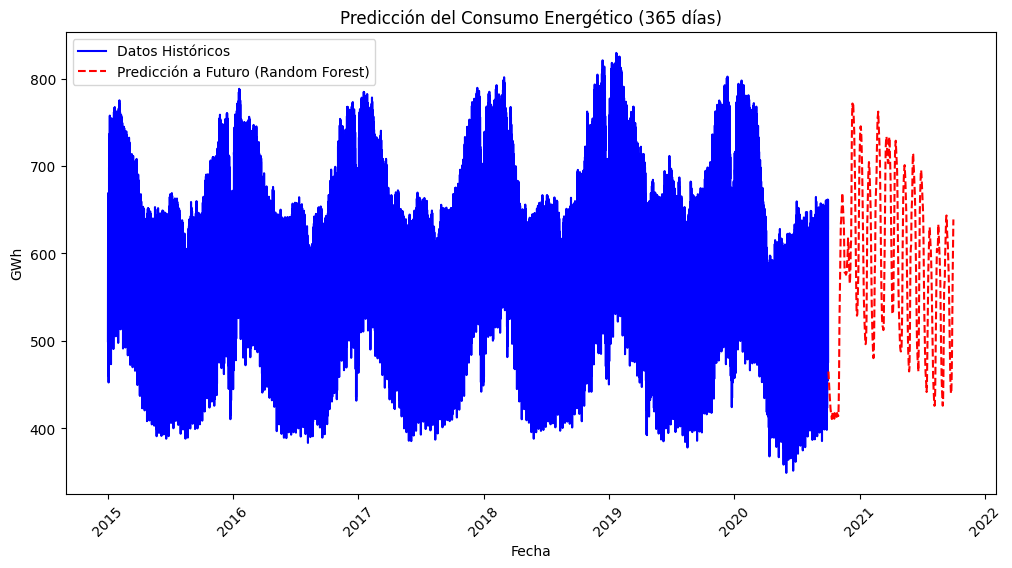

In [35]:
from datetime import timedelta

# Creamos fechas futuras (365 días)
future_dates = pd.DataFrame({'ds': pd.date_range(start=df_ml['ds'].max() + timedelta(days=1), periods=365, freq='D')})

# Inicializamos las características lag y rolling mean basadas en los últimos datos históricos
last_values = df_ml[['y']].set_index(df_ml['ds']).tail(30)

# Creamos listas para almacenar las características futuras y predicciones
future_predictions = []
lag_1_values = []
lag_7_values = []
lag_30_values = []
rolling_mean_7_values = []
rolling_mean_30_values = []

# Iteramos sobre las fechas futuras para calcular características
for i in range(365):
    # Calculamos valores lag
    if i == 0:
        lag_1 = last_values['y'].iloc[-1]  # Último valor histórico
        lag_7 = last_values['y'].iloc[-7]  # 7 días antes
        lag_30 = last_values['y'].iloc[0]  # 30 días antes
    else:
        lag_1 = future_predictions[i-1]  # Usar la predicción anterior
        lag_7 = future_predictions[i-7] if i >= 7 else last_values['y'].iloc[-7]  # Predicción o histórico
        lag_30 = future_predictions[i-30] if i >= 30 else last_values['y'].iloc[0]  # Predicción o histórico

    # Calculamos medias móviles basadas en predicciones anteriores
    rolling_mean_7 = np.mean(future_predictions[-7:]) if len(future_predictions) >= 7 else np.mean(last_values['y'][-7:])
    rolling_mean_30 = np.mean(future_predictions[-30:]) if len(future_predictions) >= 30 else np.mean(last_values['y'])

    # Guardamos valores lag y rolling means
    lag_1_values.append(lag_1)
    lag_7_values.append(lag_7)
    lag_30_values.append(lag_30)
    rolling_mean_7_values.append(rolling_mean_7)
    rolling_mean_30_values.append(rolling_mean_30)

    # Creamos un DataFrame temporal para hacer la predicción
    temp_features = pd.DataFrame({
        'year': [future_dates['ds'].dt.year.iloc[i]],
        'month': [future_dates['ds'].dt.month.iloc[i]],
        'day': [future_dates['ds'].dt.day.iloc[i]],
        'dayofweek': [future_dates['ds'].dt.dayofweek.iloc[i]],
        'lag_1': [lag_1],
        'lag_7': [lag_7],
        'lag_30': [lag_30],
        'rolling_mean_7': [rolling_mean_7],
        'rolling_mean_30': [rolling_mean_30]
    })

    # Hacemos predicción y la guardarmos
    future_pred = best_rf.predict(temp_features)[0]
    future_predictions.append(future_pred)

# ---- AGREGAMOS PREDICCIONES AL DATAFRAME ----
future_dates['prediction'] = future_predictions
future_dates['lag_1'] = lag_1_values
future_dates['lag_7'] = lag_7_values
future_dates['lag_30'] = lag_30_values
future_dates['rolling_mean_7'] = rolling_mean_7_values
future_dates['rolling_mean_30'] = rolling_mean_30_values

# ---- VISUALIZAMOS RESULTADOS ----
plt.figure(figsize=(12, 6))
plt.plot(df_ml['ds'], df_ml['y'], label="Datos Históricos", color="blue")
plt.plot(future_dates['ds'], future_dates['prediction'], label="Predicción a Futuro (Random Forest)", color="red", linestyle="dashed")
plt.title("Predicción del Consumo Energético (365 días)")
plt.xlabel("Fecha")
plt.ylabel("GWh")
plt.xticks(rotation=45)
plt.legend()
plt.show()


### Predicción del consumo energético en Europa hasta el año 2030

In [36]:
# VERIFICAMOS SI `ds` EXISTE Y ESTÁ EN FORMATO DATETIME
if 'ds' not in df_ml.columns:
    raise ValueError("❌ ERROR: La columna 'ds' no está en df_ml. Verifica el dataset original.")

df_ml['ds'] = pd.to_datetime(df_ml['ds'], errors='coerce')  # Convertimos 'ds' a datetime
df_ml = df_ml.set_index('ds')  # Establecemos 'ds' como índice

# ELIMINAMOS FILAS CON FECHAS INVÁLIDAS
df_ml = df_ml.dropna(subset=['y'])  # Eliminamos valores NaN en 'y'
df_ml = df_ml[~df_ml.index.isna()]  # Eliminamos cualquier NaT en el índice

# COMPROBAMOS QUE AHORA `df_ml.index` ES CORRECTO
print("📌 Nuevo tipo de índice:", type(df_ml.index))
print("📌 Primeras fechas corregidas en df_ml:")
print(df_ml.head())

# REVISAMOS LA ÚLTIMA FECHA PARA GENERAR PREDICCIONES
max_date = df_ml.index.max()
print(f"✅ Última fecha en datos históricos corregida: {max_date}")

# SI max_date SIGUE MAL, DETENEMOS TODO
if max_date.year < 2000:
    raise ValueError("❌ ERROR: La última fecha sigue siendo incorrecta. Verifica df_ml.")

print("✅ ✅ ✅ ¡df_ml está correctamente corregido y listo para predicción!")


📌 Nuevo tipo de índice: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
📌 Primeras fechas corregidas en df_ml:
                                   y  year  month  day  dayofweek      lag_1  \
ds                                                                             
2015-01-02 05:00:00+00:00  499.72316  2015      1    2          4  470.90571   
2015-01-02 06:00:00+00:00  533.63308  2015      1    2          4  499.72316   
2015-01-02 07:00:00+00:00  563.45514  2015      1    2          4  533.63308   
2015-01-02 08:00:00+00:00  585.91510  2015      1    2          4  563.45514   
2015-01-02 09:00:00+00:00  613.21775  2015      1    2          4  585.91510   

                               lag_7     lag_30  rolling_mean_7  \
ds                                                                
2015-01-02 05:00:00+00:00  531.11204  501.87396      477.131651   
2015-01-02 06:00:00+00:00  503.45158  501.87396      481.443294   
2015-01-02 07:00:00+00:00  480.60747  498.85396      4

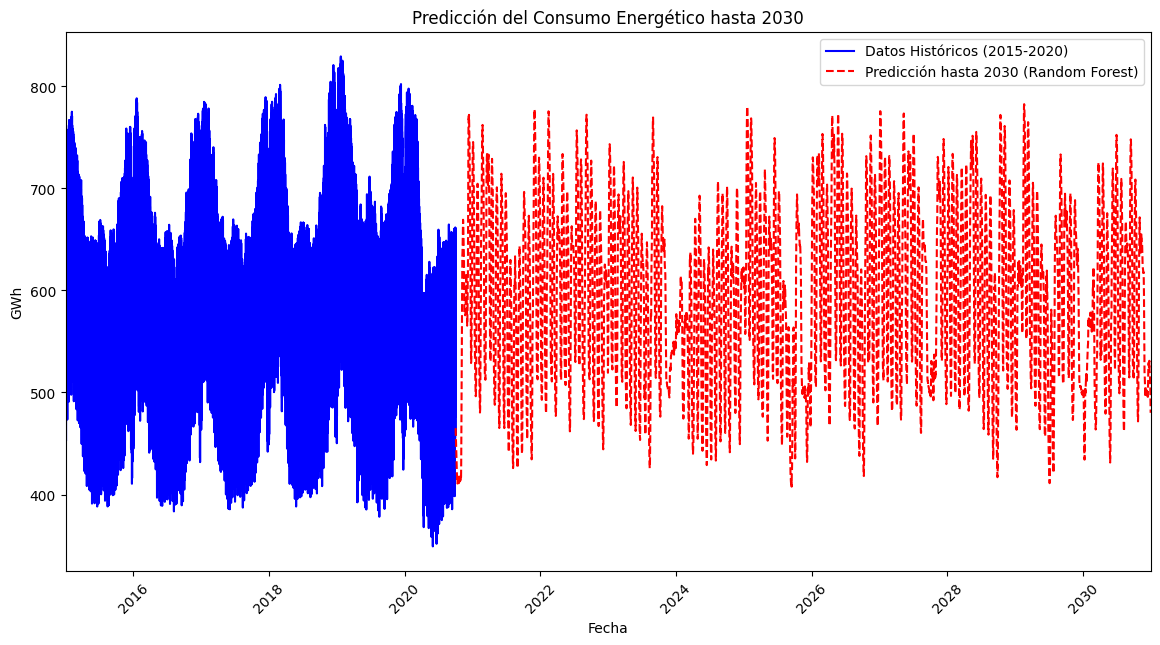

In [37]:
from datetime import timedelta

# ELIMINAMOS ZONA HORARIA SI ES NECESARIO
if hasattr(max_date, 'tz') and max_date.tz is not None:
    max_date = max_date.tz_localize(None)  # Eliminamos zona horaria

end_date = pd.to_datetime('2030-12-31')  # Aseguramos que 'end' también sea tz-naive

# GENERAMOS FECHAS FUTURAS (SIN ERRORES DE TIMEZONE)
future_dates = pd.DataFrame({'ds': pd.date_range(start=max_date + timedelta(days=1), end=end_date, freq='D')})

# INICIALIZAMOS VARIABLES
last_values = df_ml[['y']].tail(30)  # Últimos 30 valores históricos

future_predictions = []
lag_1_values, lag_7_values, lag_30_values = [], [], []
rolling_mean_7_values, rolling_mean_30_values = [], []

# GENERAMOS PREDICCIONES PARA CADA DÍA FUTURO
for i in range(len(future_dates)):
    # Calcular valores lag
    if i == 0:
        lag_1 = last_values['y'].iloc[-1]  # Último valor histórico
        lag_7 = last_values['y'].iloc[-7]  # 7 días antes
        lag_30 = last_values['y'].iloc[0]  # 30 días antes
    else:
        lag_1 = future_predictions[i-1]  
        lag_7 = future_predictions[i-7] if i >= 7 else last_values['y'].iloc[-7]
        lag_30 = future_predictions[i-30] if i >= 30 else last_values['y'].iloc[0]

    # Calculamos medias móviles
    rolling_mean_7 = np.mean(future_predictions[-7:]) if len(future_predictions) >= 7 else np.mean(last_values['y'][-7:])
    rolling_mean_30 = np.mean(future_predictions[-30:]) if len(future_predictions) >= 30 else np.mean(last_values['y'])

    # Guardamos valores lag y rolling means
    lag_1_values.append(lag_1)
    lag_7_values.append(lag_7)
    lag_30_values.append(lag_30)
    rolling_mean_7_values.append(rolling_mean_7)
    rolling_mean_30_values.append(rolling_mean_30)

    # Creamos DataFrame temporal para hacer la predicción
    temp_features = pd.DataFrame({
        'year': [future_dates['ds'].dt.year.iloc[i]],
        'month': [future_dates['ds'].dt.month.iloc[i]],
        'day': [future_dates['ds'].dt.day.iloc[i]],
        'dayofweek': [future_dates['ds'].dt.dayofweek.iloc[i]],
        'lag_1': [lag_1],
        'lag_7': [lag_7],
        'lag_30': [lag_30],
        'rolling_mean_7': [rolling_mean_7],
        'rolling_mean_30': [rolling_mean_30]
    })

    # Hacemos predicción y guardamos el resultado
    future_pred = best_rf.predict(temp_features)[0]
    future_predictions.append(future_pred)

# AGREGAMOS PREDICCIONES AL DATAFRAME
future_dates['prediction'] = future_predictions
future_dates['lag_1'] = lag_1_values
future_dates['lag_7'] = lag_7_values
future_dates['lag_30'] = lag_30_values
future_dates['rolling_mean_7'] = rolling_mean_7_values
future_dates['rolling_mean_30'] = rolling_mean_30_values

#  VISUALIZAMOS RESULTADOS
plt.figure(figsize=(14, 7))
plt.plot(df_ml.index, df_ml['y'], label="Datos Históricos (2015-2020)", color="blue")
plt.plot(future_dates['ds'], future_dates['prediction'], label="Predicción hasta 2030 (Random Forest)", color="red", linestyle="dashed")

# Evitamos errores en el gráfico asegurando el rango de fechas correcto
plt.xlim([df_ml.index.min(), future_dates['ds'].max()])

plt.title("Predicción del Consumo Energético hasta 2030")
plt.xlabel("Fecha")
plt.ylabel("GWh")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Ahora exportaremos estas predicciones en csv para su posterior analisis en herramientas como PowerBI o Tableau.

In [38]:
csv_filename = "predicciones_consumo_energetico_2030.csv"
future_dates.to_csv(csv_filename, index=False, encoding='utf-8')

print(f"✅ Predicciones exportadas correctamente como '{csv_filename}'.")

✅ Predicciones exportadas correctamente como 'predicciones_consumo_energetico_2030.csv'.


### Análisis del consumo energético por paises

Ya tenemos el consumo energético predicho hasta 2030, pero a nivel global del continente. Estos datos tienen más sentido si hacemos una segmentación por países, así que vamos a ello.

In [39]:
df_original = pd.read_csv("data/time_series_60min_singleindex.csv", parse_dates=[0], index_col=0)

print("Columnas después de recargar:")
print(df_original.columns.tolist())

Columnas después de recargar:
['cet_cest_timestamp', 'AT_load_actual_entsoe_transparency', 'AT_load_forecast_entsoe_transparency', 'AT_price_day_ahead', 'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual', 'BE_load_actual_entsoe_transparency', 'BE_load_forecast_entsoe_transparency', 'BE_solar_generation_actual', 'BE_wind_generation_actual', 'BE_wind_offshore_generation_actual', 'BE_wind_onshore_generation_actual', 'BG_load_actual_entsoe_transparency', 'BG_load_forecast_entsoe_transparency', 'BG_solar_generation_actual', 'BG_wind_onshore_generation_actual', 'CH_load_actual_entsoe_transparency', 'CH_load_forecast_entsoe_transparency', 'CH_solar_capacity', 'CH_solar_generation_actual', 'CH_wind_onshore_capacity', 'CH_wind_onshore_generation_actual', 'CY_load_actual_entsoe_transparency', 'CY_load_forecast_entsoe_transparency', 'CY_wind_onshore_generation_actual', 'CZ_load_actual_entsoe_transparency', 'CZ_load_forecast_entsoe_transparency', 'CZ_solar_generation_actual', 'CZ_wi

In [40]:
country_columns = [col for col in df_original.columns if "_load_actual_entsoe_transparency" in col]
print("Paises detectados en el dataset:", country_columns)

Paises detectados en el dataset: ['AT_load_actual_entsoe_transparency', 'BE_load_actual_entsoe_transparency', 'BG_load_actual_entsoe_transparency', 'CH_load_actual_entsoe_transparency', 'CY_load_actual_entsoe_transparency', 'CZ_load_actual_entsoe_transparency', 'DE_load_actual_entsoe_transparency', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_LU_load_actual_entsoe_transparency', 'DE_amprion_load_actual_entsoe_transparency', 'DE_tennet_load_actual_entsoe_transparency', 'DE_transnetbw_load_actual_entsoe_transparency', 'DK_load_actual_entsoe_transparency', 'DK_1_load_actual_entsoe_transparency', 'DK_2_load_actual_entsoe_transparency', 'EE_load_actual_entsoe_transparency', 'ES_load_actual_entsoe_transparency', 'FI_load_actual_entsoe_transparency', 'FR_load_actual_entsoe_transparency', 'GB_GBN_load_actual_entsoe_transparency', 'GB_NIR_load_actual_entsoe_transparency', 'GB_UKM_load_actual_entsoe_transparency', 'GR_load_actual_entsoe_transparency', 'HR_load_actual_entsoe_transparency', '

In [41]:
from collections import defaultdict

# Crear diccionario para almacenar los datos de cada país
aggregated_countries = defaultdict(list)

# Iterar sobre cada columna de consumo energético
for col in country_columns:
    country_code = col.split("_")[0]  # Extraer solo el código del país (Ej: 'DE' de 'DE_load_actual_entsoe_transparency')
    aggregated_countries[country_code].append(col)  # Guardar todas las subdivisiones en una lista

# Mostrar los países únicos detectados después de la limpieza
print("Paises únicos después de limpiar subdivisiones:", list(aggregated_countries.keys()))

Paises únicos después de limpiar subdivisiones: ['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'UA']


Ahora crearemos otro diccionario para sustitur la abreviatura de cada país por su nombre completo y así quede todo mucho más claro.

In [42]:
country_names = {
    "AT": "Austria", "BE": "Bélgica", "BG": "Bulgaria", "CH": "Suiza", "CY": "Chipre",
    "CZ": "República Checa", "DE": "Alemania", "DK": "Dinamarca", "EE": "Estonia",
    "ES": "España", "FI": "Finlandia", "FR": "Francia", "GB": "Reino Unido",
    "GR": "Grecia", "HR": "Croacia", "HU": "Hungría", "IE": "Irlanda",
    "IT": "Italia", "LT": "Lituania", "LU": "Luxemburgo", "LV": "Letonia",
    "ME": "Montenegro", "NL": "Países Bajos", "NO": "Noruega", "PL": "Polonia",
    "PT": "Portugal", "RO": "Rumania", "RS": "Serbia", "SE": "Suecia",
    "SI": "Eslovenia", "SK": "Eslovaquia", "UA": "Ucrania"
}

Debido a la gran carga que llevan todos los países, haremos una selección de países para que sea la ejecución más llevadera.

In [43]:
import pandas as pd

# FILTRAMOS SOLO LAS COLUMNAS DE CONSUMO REAL POR PAÍS
country_columns = [col for col in df_original.columns if col.endswith("_load_actual_entsoe_transparency")]

# CREAMOS UN NUEVO DATAFRAME SOLO CON LAS COLUMNAS FILTRADAS Y LA FECHA
df_countries = df_original[['cet_cest_timestamp'] + country_columns].copy()

# CONVERTIMOS LA COLUMNA DE FECHA A FORMATO DATETIME
df_countries.rename(columns={'cet_cest_timestamp': 'ds'}, inplace=True)  # Renombramos la columna de fecha
df_countries['ds'] = pd.to_datetime(df_countries['ds'], errors='coerce')  # Convertimos a datetime

# ESTABLECEMOS LA FECHA COMO ÍNDICE
df_countries.set_index('ds', inplace=True)

# ELIMINAMOS FILAS CON FECHAS INVÁLIDAS
df_countries = df_countries.dropna()

# VERIFICAMOS QUE LOS DATOS ESTÉN CORRECTOS
print("📌 Primeras filas de df_countries con datos por país:")
print(df_countries.head())

# ACTUALIZAMOS `df_ml` PARA INCLUIR LOS DATOS DE PAÍSES
df_ml = df_ml.join(df_countries, how='inner')  # Combinamos por índice

# VERIFICAMOS QUE `df_ml` AHORA CONTIENE LOS DATOS DE PAÍSES
print("📌 Columnas disponibles en df_ml después de la actualización:")
print(df_ml.columns.tolist())


📌 Primeras filas de df_countries con datos por país:
                           AT_load_actual_entsoe_transparency  \
ds                                                              
2018-10-01 02:00:00+02:00                              5197.0   
2018-10-01 03:00:00+02:00                              5121.0   
2018-10-01 04:00:00+02:00                              5276.0   
2018-10-01 05:00:00+02:00                              6012.0   
2018-10-01 06:00:00+02:00                              7349.0   

                           BE_load_actual_entsoe_transparency  \
ds                                                              
2018-10-01 02:00:00+02:00                              7726.0   
2018-10-01 03:00:00+02:00                              7592.0   
2018-10-01 04:00:00+02:00                              7771.0   
2018-10-01 05:00:00+02:00                              8352.0   
2018-10-01 06:00:00+02:00                              9599.0   

                           BG_load_

/tmp/ipykernel_23485/4199408693.py:11: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_countries['ds'] = pd.to_datetime(df_countries['ds'], errors='coerce')  # Convertimos a datetime


In [44]:
# MOSTRAR LAS COLUMNAS DISPONIBLES EN df_ml
print("📌 Columnas disponibles en df_ml después de la actualización:")
print(df_ml.columns.tolist())

# FILTRAR SOLO LAS COLUMNAS RELACIONADAS CON CONSUMO ENERGÉTICO POR PAÍS
load_columns = [col for col in df_ml.columns if "_load_actual_entsoe_transparency" in col]
print("📌 Columnas de consumo energético en df_ml:")
print(load_columns)

# REVISAR SI HAY DATOS EN df_ml
print("📌 Primeras filas de df_ml:")
print(df_ml.head())

# SI NO HAY COLUMNAS DE CONSUMO, EL ERROR ESTÁ AQUÍ
if len(load_columns) == 0:
    raise ValueError("❌ ERROR: No hay columnas de consumo energético en df_ml. Revisa la fusión de datos.")


📌 Columnas disponibles en df_ml después de la actualización:
['y', 'year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7', 'rolling_mean_30', 'AT_load_actual_entsoe_transparency', 'BE_load_actual_entsoe_transparency', 'BG_load_actual_entsoe_transparency', 'CH_load_actual_entsoe_transparency', 'CY_load_actual_entsoe_transparency', 'CZ_load_actual_entsoe_transparency', 'DE_load_actual_entsoe_transparency', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_LU_load_actual_entsoe_transparency', 'DE_amprion_load_actual_entsoe_transparency', 'DE_tennet_load_actual_entsoe_transparency', 'DE_transnetbw_load_actual_entsoe_transparency', 'DK_load_actual_entsoe_transparency', 'DK_1_load_actual_entsoe_transparency', 'DK_2_load_actual_entsoe_transparency', 'EE_load_actual_entsoe_transparency', 'ES_load_actual_entsoe_transparency', 'FI_load_actual_entsoe_transparency', 'FR_load_actual_entsoe_transparency', 'GB_GBN_load_actual_entsoe_transparency', 'GB_NIR_load_actual_entsoe

In [51]:
# ---- GENERAR PREDICCIONES POR PAÍS ----
future_predictions_per_country = {}

for country, df in country_data.items():
    # Eliminamos zona horaria si existe
    if hasattr(df.index, 'tz') and df.index.tz is not None:
        df.index = df.index.tz_localize(None)

    # Obtener la última fecha en los datos históricos
    max_date = df.index.max()

    # Asegurar que `max_date` es timezone-naive
    if hasattr(max_date, 'tz'):
        max_date = max_date.tz_localize(None)

    # Asegurar que la fecha objetivo también sea timezone-naive
    end_date = pd.to_datetime('2030-12-31').tz_localize(None)

    # Calcular número de días correctamente
    num_days = (end_date - max_date).days
    if num_days <= 0:
        print(f"⚠️ Advertencia: No se pueden generar predicciones para {country}, max_date es incorrecta.")
        continue

    # Generamos DataFrame de fechas futuras
    future_dates = pd.DataFrame({'ds': pd.date_range(start=max_date + timedelta(days=1), periods=num_days, freq='D')})

    # Inicializamos variables de predicción
    last_values = df[['y']].tail(30)
    future_predictions = []

    lag_1_values, lag_7_values, lag_30_values = [], [], []
    rolling_mean_7_values, rolling_mean_30_values = [], []

    for i in range(num_days):
        if i == 0:
            lag_1 = last_values['y'].iloc[-1]
            lag_7 = last_values['y'].iloc[-7] if len(last_values) >= 7 else lag_1
            lag_30 = last_values['y'].iloc[0] if len(last_values) >= 30 else lag_1
        else:
            lag_1 = future_predictions[i-1]
            lag_7 = future_predictions[i-7] if i >= 7 else last_values['y'].iloc[-7]
            lag_30 = future_predictions[i-30] if i >= 30 else last_values['y'].iloc[0]

        # Calcular medias móviles
        rolling_mean_7 = np.mean(future_predictions[-7:]) if len(future_predictions) >= 7 else np.mean(last_values['y'][-7:])
        rolling_mean_30 = np.mean(future_predictions[-30:]) if len(future_predictions) >= 30 else np.mean(last_values['y'])

        # Guardamos valores para incluir en el dataset final
        lag_1_values.append(lag_1)
        lag_7_values.append(lag_7)
        lag_30_values.append(lag_30)
        rolling_mean_7_values.append(rolling_mean_7)
        rolling_mean_30_values.append(rolling_mean_30)

        # Creamos DataFrame temporal para la predicción con todas las features necesarias
        temp_features = pd.DataFrame({
            'year': [future_dates['ds'].dt.year.iloc[i]],
            'month': [future_dates['ds'].dt.month.iloc[i]],
            'day': [future_dates['ds'].dt.day.iloc[i]],
            'dayofweek': [future_dates['ds'].dt.dayofweek.iloc[i]],
            'lag_1': [lag_1],
            'lag_7': [lag_7],
            'lag_30': [lag_30],
            'rolling_mean_7': [rolling_mean_7],
            'rolling_mean_30': [rolling_mean_30]  # ✅ Se añade correctamente
        })

        # Aseguramos que los features coincidan con el entrenamiento
        try:
            future_pred = best_rf.predict(temp_features)[0]
        except Exception as e:
            print(f"❌ Error en la predicción para {country}: {e}")
            future_pred = np.nan  # Si hay error, asignamos NaN

        future_predictions.append(future_pred)

    # Aseguramos que las predicciones se guardan correctamente
    future_dates['prediction'] = future_predictions
    future_dates['lag_1'] = lag_1_values
    future_dates['lag_7'] = lag_7_values
    future_dates['lag_30'] = lag_30_values
    future_dates['rolling_mean_7'] = rolling_mean_7_values
    future_dates['rolling_mean_30'] = rolling_mean_30_values

    # Imprimimos muestra para verificar
    print(f"\n📌 **Muestra de predicciones para {country}:**")
    print(future_dates.head(5))

    # Guardamos los resultados en el diccionario
    future_predictions_per_country[country] = future_dates

# ---- EXPORTAR PREDICCIONES A CSV CON NOMBRES COMPLETOS ----
for country, df in future_predictions_per_country.items():
    country_full_name = country_names.get(country, country)  # Si no está en el diccionario, usa la abreviatura
    filename = f"predicciones_{country_full_name}_2030.csv"

    # Verificamos antes de exportar
    if 'prediction' in df.columns and not df['prediction'].isna().all():
        df.to_csv(filename, index=False, encoding='utf-8')
        print(f"✅ Predicciones de {country_full_name} exportadas en '{filename}'")
    else:
        print(f"⚠️ Advertencia: No se exportó {country_full_name} porque no tiene predicciones válidas.")

print("\n🚀 **¡Predicciones completadas y exportadas exitosamente!**")


📌 **Muestra de predicciones para AT:**
                   ds  prediction        lag_1   lag_7  lag_30  \
0 2020-10-02 01:00:00  823.016743  5395.000000  7711.0  7259.0   
1 2020-10-03 01:00:00  823.904720   823.016743  7711.0  7259.0   
2 2020-10-04 01:00:00  823.628516   823.904720  7711.0  7259.0   
3 2020-10-05 01:00:00  823.783544   823.628516  7711.0  7259.0   
4 2020-10-06 01:00:00  823.783544   823.783544  7711.0  7259.0   

   rolling_mean_7  rolling_mean_30  
0     6415.428571      6788.466667  
1     6415.428571      6788.466667  
2     6415.428571      6788.466667  
3     6415.428571      6788.466667  
4     6415.428571      6788.466667  

📌 **Muestra de predicciones para BE:**
                   ds  prediction        lag_1    lag_7   lag_30  \
0 2020-10-02 01:00:00  823.016743  7837.000000  10317.0  10288.0   
1 2020-10-03 01:00:00  823.904720   823.016743  10317.0  10288.0   
2 2020-10-04 01:00:00  823.628516   823.904720  10317.0  10288.0   
3 2020-10-05 01:00:00  823.78

In [52]:
import os

# Obtenemos todos los archivos CSV en el directorio actual
csv_files = [f for f in os.listdir() if f.startswith("predicciones_") and f.endswith(".csv")]

# Graficar cada país
for csv_file in csv_files:
    # Extraemos el nombre del país
    country_name = csv_file.replace("predicciones_", "").replace("_2030.csv", "")

    # Cargamos datos históricos y predicciones
    df = pd.read_csv(csv_file)

    # Nos aseguramos que la fecha esté en formato datetime
    df['ds'] = pd.to_datetime(df['ds'])

    # Creamos la gráfica
    plt.figure(figsize=(14, 6))
    plt.plot(df['ds'], df['prediction'], label="Predicción (2022-2030)", color="red", linestyle="dashed")

    # Configuramos la gráfica
    plt.title(f"Predicción del Consumo Energético en {country_name} (2022-2030)")
    plt.xlabel("Fecha")
    plt.ylabel("Consumo Energético (GWh)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()

    # Guardamos la imagen
    filename = f"grafico_prediccion_{country_name}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"✅ Gráfico guardado como: {filename}")

print("\n🚀 **¡Todas las predicciones han sido graficadas exitosamente!**")

✅ Gráfico guardado como: grafico_prediccion_España.png
✅ Gráfico guardado como: grafico_prediccion_Irlanda.png
✅ Gráfico guardado como: grafico_prediccion_Francia.png
✅ Gráfico guardado como: grafico_prediccion_Lituania.png
✅ Gráfico guardado como: grafico_prediccion_Montenegro.png
✅ Gráfico guardado como: grafico_prediccion_Bélgica.png
✅ Gráfico guardado como: grafico_prediccion_Luxemburgo.png
✅ Gráfico guardado como: grafico_prediccion_Alemania.png
✅ Gráfico guardado como: grafico_prediccion_Bulgaria.png
✅ Gráfico guardado como: grafico_prediccion_Italia.png
✅ Gráfico guardado como: grafico_prediccion_Rumania.png
✅ Gráfico guardado como: grafico_prediccion_Eslovaquia.png
✅ Gráfico guardado como: grafico_prediccion_Austria.png
✅ Gráfico guardado como: grafico_prediccion_Dinamarca.png
✅ Gráfico guardado como: grafico_prediccion_Reino Unido.png
✅ Gráfico guardado como: grafico_prediccion_Serbia.png
✅ Gráfico guardado como: grafico_prediccion_Eslovenia.png
✅ Gráfico guardado como: grafic

In [53]:
import os
from datetime import timedelta
from collections import defaultdict

# Crea carpetas si no existen
os.makedirs("data/predicciones", exist_ok=True)
os.makedirs("results", exist_ok=True)

# ---- DICCIONARIO DE PAÍSES ----
country_names = {
    "AT": "Austria", "BE": "Bélgica", "BG": "Bulgaria", "CH": "Suiza", "CY": "Chipre",
    "CZ": "República Checa", "DE": "Alemania", "DK": "Dinamarca", "EE": "Estonia",
    "ES": "España", "FI": "Finlandia", "FR": "Francia", "GB": "Reino Unido",
    "GR": "Grecia", "HR": "Croacia", "HU": "Hungría", "IE": "Irlanda",
    "IT": "Italia", "LT": "Lituania", "LU": "Luxemburgo", "LV": "Letonia",
    "ME": "Montenegro", "NL": "Países Bajos", "NO": "Noruega", "PL": "Polonia",
    "PT": "Portugal", "RO": "Rumania", "RS": "Serbia", "SE": "Suecia",
    "SI": "Eslovenia", "SK": "Eslovaquia", "UA": "Ucrania"
}

# ---- AGRUPAR COLUMNAS POR PAÍS ----
aggregated_countries = defaultdict(list)

for col in df_original.columns:
    if "_load_actual_entsoe_transparency" in col:
        country_code = col.split("_")[0]  # Extraer el código del país
        aggregated_countries[country_code].append(col)  # Guardar subdivisiones en la lista

# ---- CREAR DATAFRAMES POR PAÍS ----
country_data = {}

for country_code, cols in aggregated_countries.items():
    df_country = df_original[['cet_cest_timestamp'] + cols].copy()
    df_country.rename(columns={'cet_cest_timestamp': 'ds'}, inplace=True)

    # Convertir fechas a datetime y eliminar zona horaria si existe
    df_country['ds'] = pd.to_datetime(df_country['ds'], errors='coerce')
    if hasattr(df_country['ds'], 'dt') and df_country['ds'].dt.tz is not None:
        df_country['ds'] = df_country['ds'].dt.tz_localize(None)

    # Sumar todas las subdivisiones del país en un solo valor de consumo
    df_country['y'] = df_country[cols].sum(axis=1)

    # Mantener solo columnas necesarias
    df_country = df_country[['ds', 'y']]
    df_country.dropna(inplace=True)
    df_country.set_index('ds', inplace=True)

    if len(df_country) > 100:
        country_data[country_code] = df_country

# ---- GENERAR PREDICCIONES POR PAÍS ----
future_predictions_per_country = {}

for country, df in country_data.items():
    if hasattr(df.index, 'tz') and df.index.tz is not None:
        df.index = df.index.tz_localize(None)

    max_date = df.index.max()
    if hasattr(max_date, 'tz'):
        max_date = max_date.tz_localize(None)

    end_date = pd.to_datetime('2030-12-31').tz_localize(None)
    num_days = (end_date - max_date).days
    if num_days <= 0:
        print(f"⚠️ No se pueden generar predicciones para {country}, max_date es incorrecta.")
        continue

    future_dates = pd.DataFrame({'ds': pd.date_range(start=max_date + timedelta(days=1), periods=num_days, freq='D')})

    last_values = df[['y']].tail(30)
    future_predictions = []

    lag_1_values, lag_7_values, lag_30_values = [], [], []
    rolling_mean_7_values, rolling_mean_30_values = [], []

    for i in range(num_days):
        if i == 0:
            lag_1 = last_values['y'].iloc[-1]
            lag_7 = last_values['y'].iloc[-7] if len(last_values) >= 7 else lag_1
            lag_30 = last_values['y'].iloc[0] if len(last_values) >= 30 else lag_1
        else:
            lag_1 = future_predictions[i-1]
            lag_7 = future_predictions[i-7] if i >= 7 else last_values['y'].iloc[-7]
            lag_30 = future_predictions[i-30] if i >= 30 else last_values['y'].iloc[0]

        rolling_mean_7 = np.mean(future_predictions[-7:]) if len(future_predictions) >= 7 else np.mean(last_values['y'][-7:])
        rolling_mean_30 = np.mean(future_predictions[-30:]) if len(future_predictions) >= 30 else np.mean(last_values['y'])

        temp_features = pd.DataFrame({
            'year': [future_dates['ds'].dt.year.iloc[i]],
            'month': [future_dates['ds'].dt.month.iloc[i]],
            'day': [future_dates['ds'].dt.day.iloc[i]],
            'dayofweek': [future_dates['ds'].dt.dayofweek.iloc[i]],
            'lag_1': [lag_1],
            'lag_7': [lag_7],
            'lag_30': [lag_30],
            'rolling_mean_7': [rolling_mean_7],
            'rolling_mean_30': [rolling_mean_30]
        })

        try:
            future_pred = best_rf.predict(temp_features)[0]
        except Exception as e:
            print(f"❌ Error en la predicción para {country}: {e}")
            future_pred = np.nan  

        future_predictions.append(future_pred)

    future_dates['prediction'] = future_predictions
    future_predictions_per_country[country] = future_dates

    # Guardamos las gráficas
    plt.figure(figsize=(14, 6))
    plt.plot(future_dates['ds'], future_dates['prediction'], label="Predicción (2022-2030)", color="red", linestyle="dashed")
    plt.title(f"Consumo Energético en {country_names.get(country, country)} (2022-2030)")
    plt.xlabel("Fecha")
    plt.ylabel("Consumo Energético (GWh)")
    plt.legend()
    plt.grid()
    plt.savefig(f"results/grafico_prediccion_{country}.png", dpi=300, bbox_inches="tight")
    plt.close()

# ---- EXPORTAR PREDICCIONES A CSV ----
for country, df in future_predictions_per_country.items():
    filename = f"data/predicciones/predicciones_{country_names.get(country, country)}_2030.csv"
    df.to_csv(filename, index=False, encoding='utf-8')
    print(f"✅ Predicciones exportadas en '{filename}'")

print("\n🚀 **¡Todo se ha guardado correctamente en las carpetas correspondientes!**")

/tmp/ipykernel_23485/3254770780.py:37: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_country['ds'] = pd.to_datetime(df_country['ds'], errors='coerce')
/tmp/ipykernel_23485/3254770780.py:37: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_country['ds'] = pd.to_datetime(df_country['ds'], errors='coerce')
/tmp/ipykernel_23485/3254770780.py:37: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an e

✅ Predicciones exportadas en 'data/predicciones/predicciones_Austria_2030.csv'
✅ Predicciones exportadas en 'data/predicciones/predicciones_Bélgica_2030.csv'
✅ Predicciones exportadas en 'data/predicciones/predicciones_Bulgaria_2030.csv'
✅ Predicciones exportadas en 'data/predicciones/predicciones_Suiza_2030.csv'
✅ Predicciones exportadas en 'data/predicciones/predicciones_Chipre_2030.csv'
✅ Predicciones exportadas en 'data/predicciones/predicciones_República Checa_2030.csv'
✅ Predicciones exportadas en 'data/predicciones/predicciones_Alemania_2030.csv'
✅ Predicciones exportadas en 'data/predicciones/predicciones_Dinamarca_2030.csv'
✅ Predicciones exportadas en 'data/predicciones/predicciones_Estonia_2030.csv'
✅ Predicciones exportadas en 'data/predicciones/predicciones_España_2030.csv'
✅ Predicciones exportadas en 'data/predicciones/predicciones_Finlandia_2030.csv'
✅ Predicciones exportadas en 'data/predicciones/predicciones_Francia_2030.csv'
✅ Predicciones exportadas en 'data/predicc